### Problem Background

Suppose we have the following function or forward model,

$$G(\mathbf{x},\mathbf{m}) = m_0 e^{m_1\mathbf{x}} + m_2 \mathbf{x} e^{m_3\mathbf{x}}$$

where $\mathbf{x}$ and $\mathbf{m}$ are vectors and the operations are element-wise, as you would expect `numpy` to do on arrays. That is to say, for $N$ length array $\mathbf{x}$, $G$ will have $N$ values. Also assume we have data set $\mathbf{d} = (d_0,d_1,d_2,...)$ that can explained (or 'fit') by this function. We would like to know the values of the parameters $\mathbf{m} = (m_0,m_1,m_2,m_3)$ that best explain the data using the function $G(x,\mathbf{m})$. Further, we would like to know the distribution of those parameters $\mathbf{m}$.

For the purpose of experimentation, let us assume that we know the true values of $\mathbf{m_t}$ are $(1.0,-0.5,1.0,-0.75)$. Further suppose the 'data', $\mathbf{d}$ can be generated by creating a vector $\mathbf{x}$, and evaluating $G(\mathbf{x},\mathbf{m_t})$ and then adding measurement noise in the form of $N(0,\sigma)$. Here the $\mathbf{x}$ should be 25 equally spaced values on the interval [1,7]. The data noise should be characterized by $\sigma = $ 0.01 where $N(0,\sigma)$ is a Gaussian with 0 mean and standard deviation $\sigma$. Perhaps you'll find this easier to understand in the code below.

In [2]:
import numpy as np

def G(x,m):
    """ you can do this, write the function"""
    y = m[0] * np.exp(m[1] * x) + m[2] * np.exp(m[3] * x)
    return y

sigma = 0.01
x = np.linspace(1,7,25)
m_t = np.array([1,-.5,1,-.75])  # These are the true values that we will attempt to recover

d = G(x,m_t) + np.random.randn(x.size) * sigma  # The 'data' which we generate with a noise signal

As you should now know, the sampling will require a so-called likelihood function, or the probability of encountering the data, given some set of $\mathbf{m}$. If we assume errors are Gaussian, or normally distributed, as we did for the noise on the observations, then the likelihood will be

$$q(\mathbf{d} | \mathbf{m}) = \prod_{i=1}^n e^{-\frac{1}{2}(d_i - G(x_i,\mathbf{m}))^2 / \sigma^2}$$

This is great, but we are taking a product of many small numbers here and the potential for underflow is real. So, we take the natural $\log$ of this:

$$\log(q(\mathbf{d}|\mathbf{m})) = -\frac{1}{2} \sum_{i=1}^n (d_i - G(x_i,\mathbf{m})^2/\sigma^2$$

The acceptance rates are in general

$$\alpha(\mathbf{m_p},\mathbf{m}) = \min\left(1,\frac{q(\mathbf{d} | \mathbf{m_p})}{q(\mathbf{d} | \mathbf{m})}\right)$$

Taking the $\log$ of the acceptance rates gives

$$ \log(\alpha) = \min(0,\log(q(\mathbf{d}|\mathbf{m_p})) -\log(q(\mathbf{d}|\mathbf{m})))$$

where $\mathbf{m}_p$ is the proposed $\mathbf{m}$. Don't forget that because the acceptance rate is the $\log$ of liklihood calculations, then we must take the $\log$ of the uniform random number from the interval [0,1] as well.

### Problem ###

Determine distributions for the parameters $\mathbf{m}$ by using MCMC to sample the posterior distributions. Use uniformly distributed random numbers for $\mathbf{m}_o$, the intial values of the parameters: $m_0 \in [0,2]$, $m_1 \in [-1,0]$, $m_2 \in [0,2]$, $m_3 \in [-1,0]$. Do a "burn-in" of 10,000 samples, followed by a chain of 400,000 samples. In each MCMC step, generate a proposal by adding normally distributed random numbers with a mean of zero and standard deviation of 0.005 to $\mathbf{m}$.

Once the simulation is complete, resample the MCMC chain by taking only every 1000th set of $\mathbf{m}$ from the full chain. Plot histograms for each variable, and compute means and standard deviations on the resulting distributions. How close are you to 'truth'?

Consider the following question: would it be better to double the size of the data set, or halve the errors in the data?

#### Hints ####
Syntacitically, the `scipy.stats.norm` is often cleaner than `numpy.random.randn` for generating random numbers.

Check and recheck your formula for the likelihood. It's critical but easy to make mistakes on parentheses.

It takes a long time to run 400,000 samples. For testing just do 100,000. You'll get the sense of things from that.

The acceptance rate is around 40%. Compute it and check against this value to see if you're doing things right.

Truthfully, I had a hard time getting this to work right. The forward model is very sensitive to small changes. Don't kill yourself on this assignment. Something that looks close will grade well.



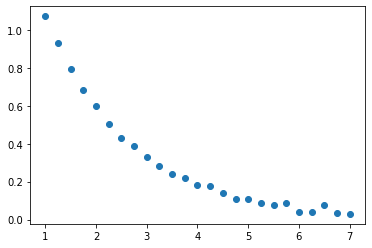

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, d, 'o')

In [4]:
def MCMC(steps, x, y, G):

    m = np.array([np.random.uniform(0, 2), np.random.uniform(-1, 0), np.random.uniform(0, 2), np.random.uniform(-1, 0)])
    chain = [m]
    accepted = 0
    for _ in range(steps):

        proposal = m + np.random.randn(4) * 0.005
        prop_likelihood = -0.5 * np.sum(((y - G(x, proposal)) ** 2) / (np.std(y - G(x, proposal)) ** 2))
        old_likelihood = -0.5 * np.sum(((y - G(x, m)) ** 2) / (np.std(y - G(x, m)) ** 2))
        if prop_likelihood - old_likelihood < 0 or old_likelihood - prop_likelihood > np.log(np.random.random()):
            m = proposal
            chain.append(m)
            accepted += 1
    print(f"Acceptance: {accepted/ steps * 100:.2f}%")
    return chain

In [5]:
def G(x,m):
    """ you can do this, write the function"""
    y = m[0] * np.exp(m[1] * x) + m[2] * np.exp(m[3] * x)
    return y

sigma = 0.01
x = np.linspace(1,7,25)
m_t = np.array([1,-.5,1,-.75])  # These are the true values that we will attempt to recover

data = G(x,m_t) + np.random.randn(x.size) * sigma

In [6]:
steps = 500000
chain = MCMC(steps, x, data, G)

Acceptance: 26.48%


In [7]:
filtered_chain = []
for i in range(0, len(chain), 1000):
    filtered_chain.append(chain[i])

filtered_chain = np.array(filtered_chain)
m_0 = filtered_chain[:, 0]
m_1 = filtered_chain[:, 1]
m_2 = filtered_chain[:, 2]
m_3 = filtered_chain[:, 3]



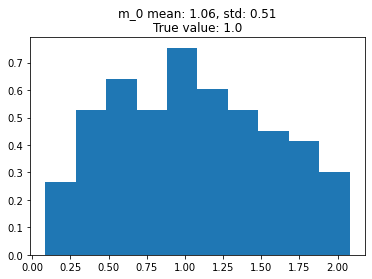

In [8]:
plt.title(f"m_0 mean: {np.mean(m_0):0.2f}, std: {np.std(m_0):0.2f}\nTrue value: {m_t[0]}")
plt.hist(m_0, density=True)
plt.show()

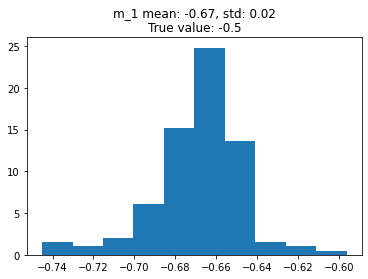

In [9]:
plt.title(f"m_1 mean: {np.mean(m_1):0.2f}, std: {np.std(m_1):0.2f}\nTrue value: {m_t[1]}")
plt.hist(m_1, density=True)
plt.show()

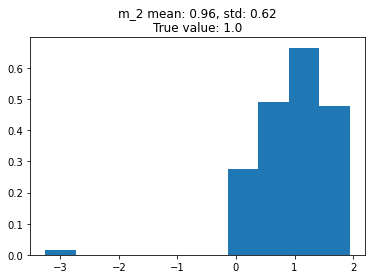

In [10]:
plt.title(f"m_2 mean: {np.mean(m_2):0.2f}, std: {np.std(m_2):0.2f}\nTrue value: {m_t[2]}")
plt.hist(m_2, density=True)
plt.show()



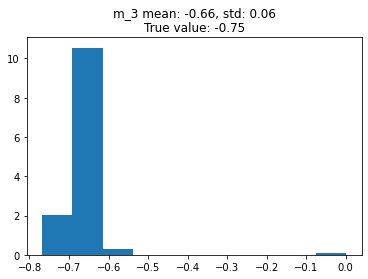

In [11]:
plt.title(f"m_3 mean: {np.mean(m_3):0.2f}, std: {np.std(m_3):0.2f}\nTrue value: {m_t[3]}")
plt.hist(m_3, density=True)
plt.show()